In [1]:
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

from process import Process

In [4]:
# image_path_left = './photo/tsukuba_l.png'
# image_path_right = './photo/tsukuba_r.png'
# image_path_left = './photo/ambush_5_left.jpg'
# image_path_right = './photo/ambush_5_right.jpg'
# image_path_left = './photo/im0.png'
# image_path_right = './photo/im1.png'
# image_path_left = './photo/fountain02.jpg'
# image_path_right = './photo/fountain03.jpg'
image_path_left = './photo/myszka01.jpg'
image_path_right = './photo/myszka02.jpg'

In [5]:
imL = Process(image_path_left)
imL.resize_image(357, 250)
arrL = imL.get_array()
imL.get_info()

imR = Process(image_path_right)
imR.resize_image(357, 250)
arrR = imR.get_array()
imR.get_info()

Image size: (357, 250)
Image mode: L
Image size: (357, 250)
Image mode: L


((357, 250), 'L')

In [6]:
from scipy import ndimage

# activate for laplacian filter
arrL_filtered = ndimage.laplace(arrL)
arrR_filtered = ndimage.laplace(arrR)

array_left = arrL
array_right = arrR

In [7]:
"""
Calculate Disparity using shit i tried earlier
"""
import cv2

wsizeV3 = 7
max_dispV3 = 160
wls_lambdaV3 = 8000
wls_sigmaV3 = 1.5

left_matcherV3 = cv2.StereoSGBM_create()
wls_filterV3 = cv2.ximgproc.createDisparityWLSFilter(left_matcherV3)
right_matcherV3 = cv2.ximgproc.createRightMatcher(left_matcherV3)


def getDispV3(imgL, imgR):
    left_for_matcher = cv2.cvtColor(imgL,  cv2.COLOR_BGR2GRAY)
    right_for_matcher = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    left_disp = left_matcherV3.compute(left_for_matcher, right_for_matcher)
    right_disp = right_matcherV3.compute(right_for_matcher, left_for_matcher)

    wls_filterV3.setLambda(wls_lambdaV3)
    wls_filterV3.setSigmaColor(wls_sigmaV3)
    filtered_disp = wls_filterV3.filter(left_disp,imgL,disparity_map_right=right_disp)

    vis = cv2.ximgproc.getDisparityVis(filtered_disp)
    disp = cv2.normalize(vis, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    
    # disp2 = np.dstack((disp, disp, disp))
    return disp

resizeSize = (357, 250)
imgL = cv2.imread(image_path_left, cv2.IMREAD_COLOR)
imgR = cv2.imread(image_path_right, cv2.IMREAD_COLOR)
imgL = cv2.resize(imgL, resizeSize)
imgR = cv2.resize(imgR, resizeSize)

disp_matrix = getDispV3(imgL, imgR)

In [8]:
print(np.max(disp_matrix))
print(np.min(disp_matrix))

255
0


In [9]:
"""
Skip postprocessing for this above
"""
rgb = []
xyzrgb = []
for x in range(disp_matrix.shape[1]):
    for y in range(disp_matrix.shape[0]):
        rgb = imgL[y, x].astype(np.float) / 255.0
# xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])
        xyzrgb.append([x, y, disp_matrix[y][x], rgb[0], rgb[1], rgb[2]])

xyzrgbetter = np.array(xyzrgb)
# xyz = xyzrgb[:, :3]
# print(np.max(xyz))
# print(np.min(xyz))

/tmp/ipykernel_7097/2826341802.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = imgL[y, x].astype(np.float) / 255.0


In [10]:
"""
Recycle Bin Image Calibration
_____________________________

Calculate the z-coordinate for each pixel using constants in 'calib.txt'
"""

z_matrix = np.copy(disp_matrix)

for i in np.nditer(z_matrix):
    i = 178.232 * 2945.377 / (i + 170.681)

z_matrix

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 51, 34, 34],
       [ 0,  0,  0, ..., 51, 34, 34],
       [ 0,  0,  0, ..., 51, 34, 34]], dtype=uint8)

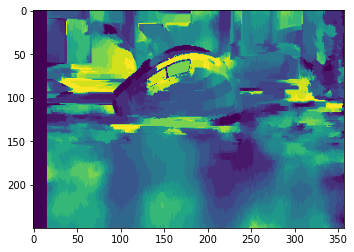

In [11]:
plt.imshow(disp_matrix)
# plt.savefig('./data/output/MPL.png')

In [12]:
"""
Optional: Save matrix in a .pkl file for future usage.
"""

import pickle

with open('z.pkl', 'wb') as f:
    pickle.dump(z_matrix, f)

In [14]:
import open3d as o3d


# filename = os.path.join(os.path.abspath(os.path.dirname(__file__)),'z.pkl')
# filename = os.path.join(os.path.abspath(os.path.dirname(__file__)),'point_cloud.txt')
print("Load a ply point cloud, print it, and render it")
# pcd = o3d.io.read_point_cloud("../../TestData/fragment.ply")
# pcd = o3d.io.read_point_cloud(filename, format = 'xyz', remove_nan_points=False, remove_infinite_points=False, print_progress= True)
# pcd = o3d.io.read_point_cloud("./point_cloud.txt", format = 'xyzrgb')

pcd = o3d.geometry.PointCloud()
xd = xyzrgbetter[:, :3]
xdd = xyzrgbetter[:, 3:]
pcd.points = o3d.utility.Vector3dVector(xd)
pcd.colors = o3d.utility.Vector3dVector(xdd)

print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])

print("Downsample the point cloud with a voxel of 0.05")
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd])

print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
    radius=0.1, max_nn=30))
o3d.visualization.draw_geometries([downpcd])

print("Print a normal vector of the 0th point")
print(downpcd.normals[0])
print("Print the normal vectors of the first 10 points")
print(np.asarray(downpcd.normals)[:10, :])
print("")

print("Load a polygon volume and use it to crop the original point cloud")
vol = o3d.visualization.read_selection_polygon_volume(
    "../../TestData/Crop/cropped.json")
chair = vol.crop_point_cloud(pcd)
o3d.visualization.draw_geometries([chair])
print("")

print("Paint chair")
chair.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([chair])
print("")

Load a ply point cloud, print it, and render it
PointCloud with 89250 points.
[[  0.   0.   0.]
 [  0.   1.   0.]
 [  0.   2.   0.]
 ...
 [356. 247.  34.]
 [356. 248.  34.]
 [356. 249.  34.]]
Downsample the point cloud with a voxel of 0.05
Recompute the normal of the downsampled point cloud
Print a normal vector of the 0th point
[0. 0. 1.]
Print the normal vectors of the first 10 points
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

Load a polygon volume and use it to crop the original point cloud
[Open3D WARNING] Read JSON failed: unable to open file: ../../TestData/Crop/cropped.json

Paint chair

